In [3]:
!pip install --quiet kaggle                 # install Kaggle API client
!mkdir -p ~/.kaggle                         # ensure hidden dir exists
!cp kaggle.json ~/.kaggle/                  # move token into place
!chmod 600 ~/.kaggle/kaggle.json            # secure your token file

In [4]:
!kaggle datasets download mkechinov/ecommerce-behavior-data-from-multi-category-store --unzip

Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
 99% 4.25G/4.29G [01:15<00:01, 23.6MB/s]
100% 4.29G/4.29G [01:15<00:00, 61.3MB/s]


# EDA and Preprocessing

## Part 1

In [5]:
import pandas as pd

# -------------------------------
# CONFIGURATION
# -------------------------------
FILE_PATH    = '/content/2019-Oct.csv'  # adjust to your file location
PRELOAD_ROWS = 10_000_000                 # rows to read before sampling 5_501_979
SAMPLE_FRAC  = 0.05                     # fraction to sample in-memory

# -------------------------------
# 1. Load a manageable chunk
# -------------------------------
df_preload = pd.read_csv(
    FILE_PATH,
    nrows=PRELOAD_ROWS,
    parse_dates=['event_time']
)

# -------------------------------
# 2. In-memory random sampling
# -------------------------------
df = df_preload.sample(frac=SAMPLE_FRAC, random_state=42)

# -------------------------------
# 3. event_time summary
# -------------------------------
print("## event_time Summary")
print(df['event_time'].describe())

# -------------------------------
# 4. DataFrame structure
# -------------------------------
print("\n## DataFrame Info")
df.info()

# -------------------------------
# 5. Overall descriptive stats
# -------------------------------
print("\n## Descriptive Statistics (describe)")
print(df.describe(include='all'))

# -------------------------------
# 6. Detailed numeric summary
# -------------------------------
numeric_cols = df.select_dtypes(include='number').columns
means       = df[numeric_cols].mean()
medians     = df[numeric_cols].median()
stds        = df[numeric_cols].std()
quantiles   = df[numeric_cols].quantile([0.25, 0.5, 0.75])
iqr         = quantiles.loc[0.75] - quantiles.loc[0.25]

print("\n## Numeric Feature Summary")
for col in numeric_cols:
    q25 = quantiles.at[0.25, col]
    q50 = quantiles.at[0.50, col]
    q75 = quantiles.at[0.75, col]
    print(f"\n### {col}")
    print(f"Mean   : {means[col]:.4f}")
    print(f"Median : {medians[col]:.4f}")
    print(f"Std    : {stds[col]:.4f}")
    print(f"25%    : {q25:.4f}")
    print(f"50%    : {q50:.4f}")
    print(f"75%    : {q75:.4f}")
    print(f"IQR    : {iqr[col]:.4f}")

# -------------------------------
# 7. Categorical feature summary
# -------------------------------
cat_cols = df.select_dtypes(include=['object', 'category']).columns

print("\n## Categorical Feature Summary")
for col in cat_cols:
    non_null = df[col].count()
    unique   = df[col].nunique()
    top10    = df[col].value_counts().head(10)
    print(f"\n### {col}")
    print(f"Non-null count : {non_null}")
    print(f"Unique values  : {unique}")
    print("Top 10 frequencies:")
    print(top10.to_string())

## event_time Summary
count                                 500000
mean     2019-10-04 23:31:08.676220416+00:00
min                2019-10-01 00:00:13+00:00
25%      2019-10-03 03:21:58.750000128+00:00
50%                2019-10-05 01:17:09+00:00
75%      2019-10-06 18:17:15.249999872+00:00
max                2019-10-08 17:26:08+00:00
Name: event_time, dtype: object

## DataFrame Info
<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 919213 to 4331277
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     500000 non-null  datetime64[ns, UTC]
 1   event_type     500000 non-null  object             
 2   product_id     500000 non-null  int64              
 3   category_id    500000 non-null  int64              
 4   category_code  338730 non-null  object             
 5   brand          430141 non-null  object             
 6   price          500000 non-null  float64 

Initial dataset shape: (500000, 9)
Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 919213 to 4331277
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     500000 non-null  datetime64[ns, UTC]
 1   event_type     500000 non-null  object             
 2   product_id     500000 non-null  int64              
 3   category_id    500000 non-null  int64              
 4   category_code  338730 non-null  object             
 5   brand          430141 non-null  object             
 6   price          500000 non-null  float64            
 7   user_id        500000 non-null  int64              
 8   user_session   500000 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 38.1+ MB
None
Data preview:
%s                        event_time event_type  product_id          category_id            category_code  

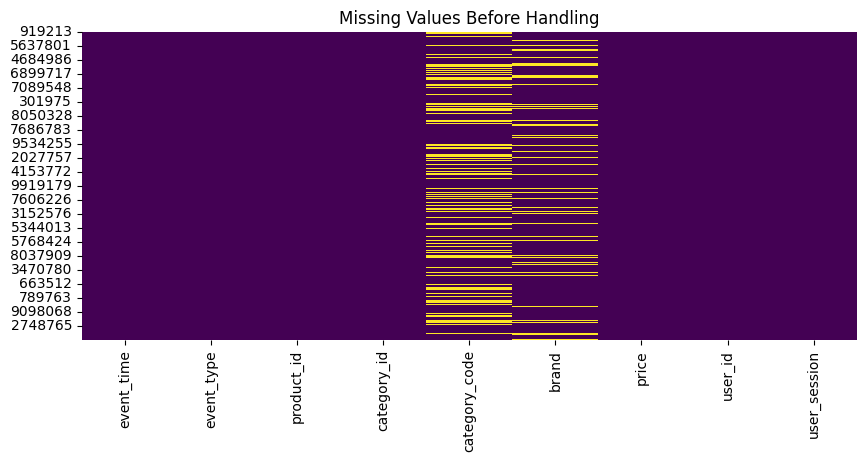

Missing % in brand & category_code:
 brand            0.139718
category_code    0.322540
dtype: float64
✅ Missing values handled.


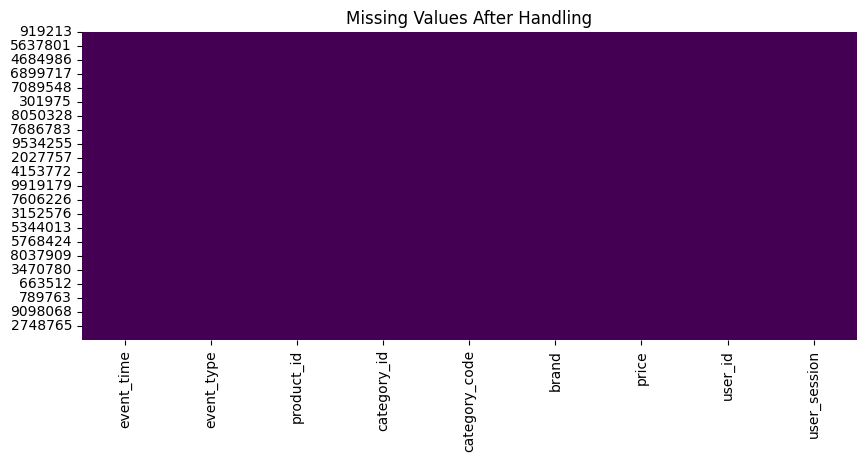

Found 26 duplicate rows.
✅ Duplicates removed.
✅ All sessions are sorted by event_time.
✅ Event type one-hot encoding completed.


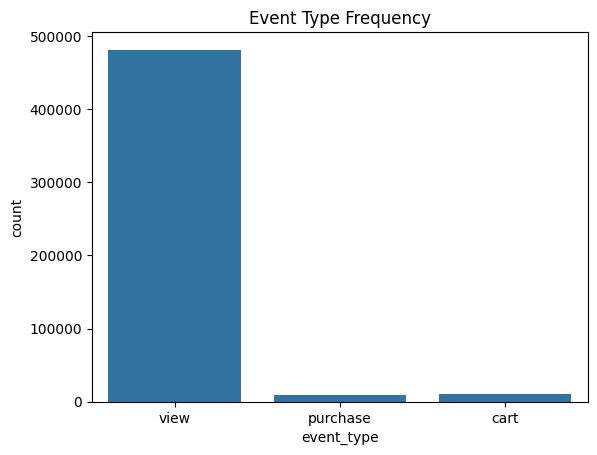

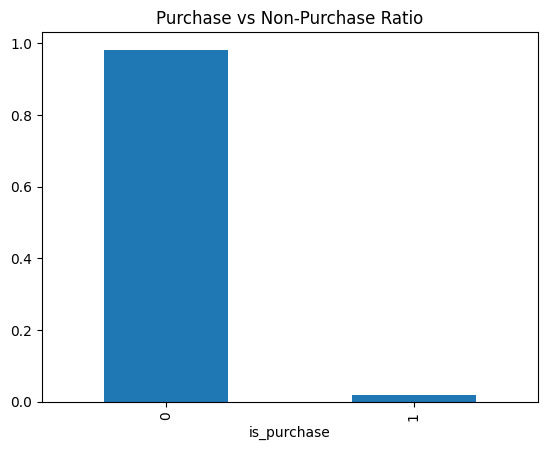

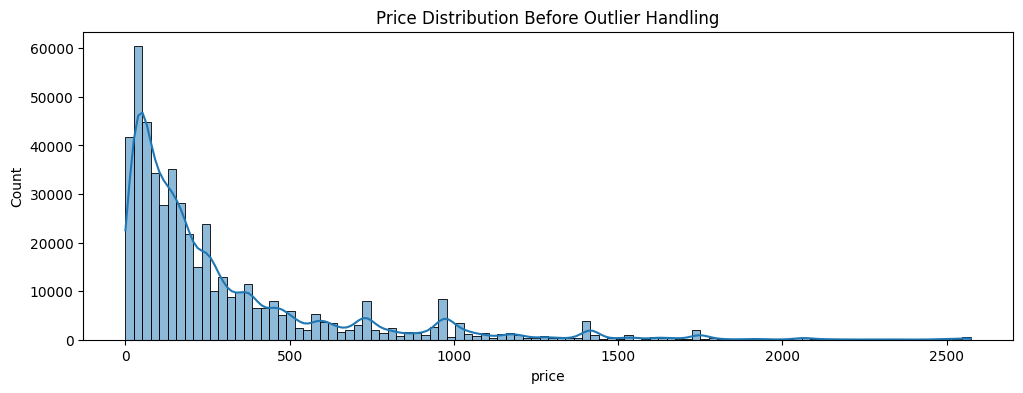

Price skewness: 2.46
Applied log1p to price.
Capped outliers in price_log to [1.61, 8.47].


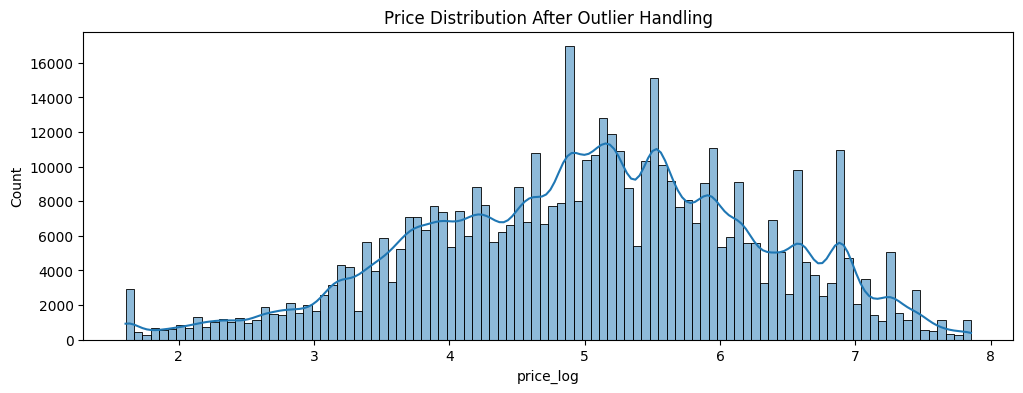

✅ Session duration feature added.
✅ Session-level aggregates added.
✅ PCA completed. Explained Variance: [0.48272316 0.22318439]


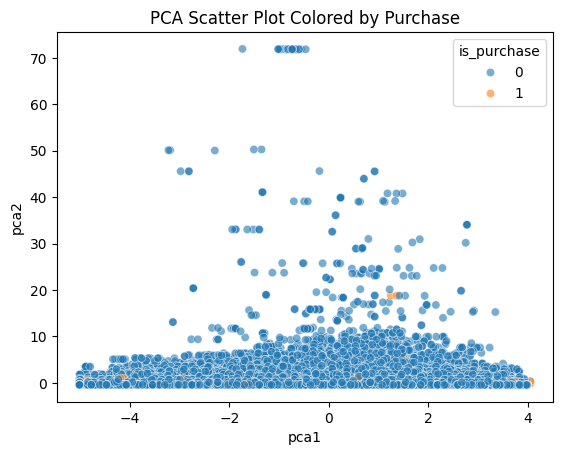

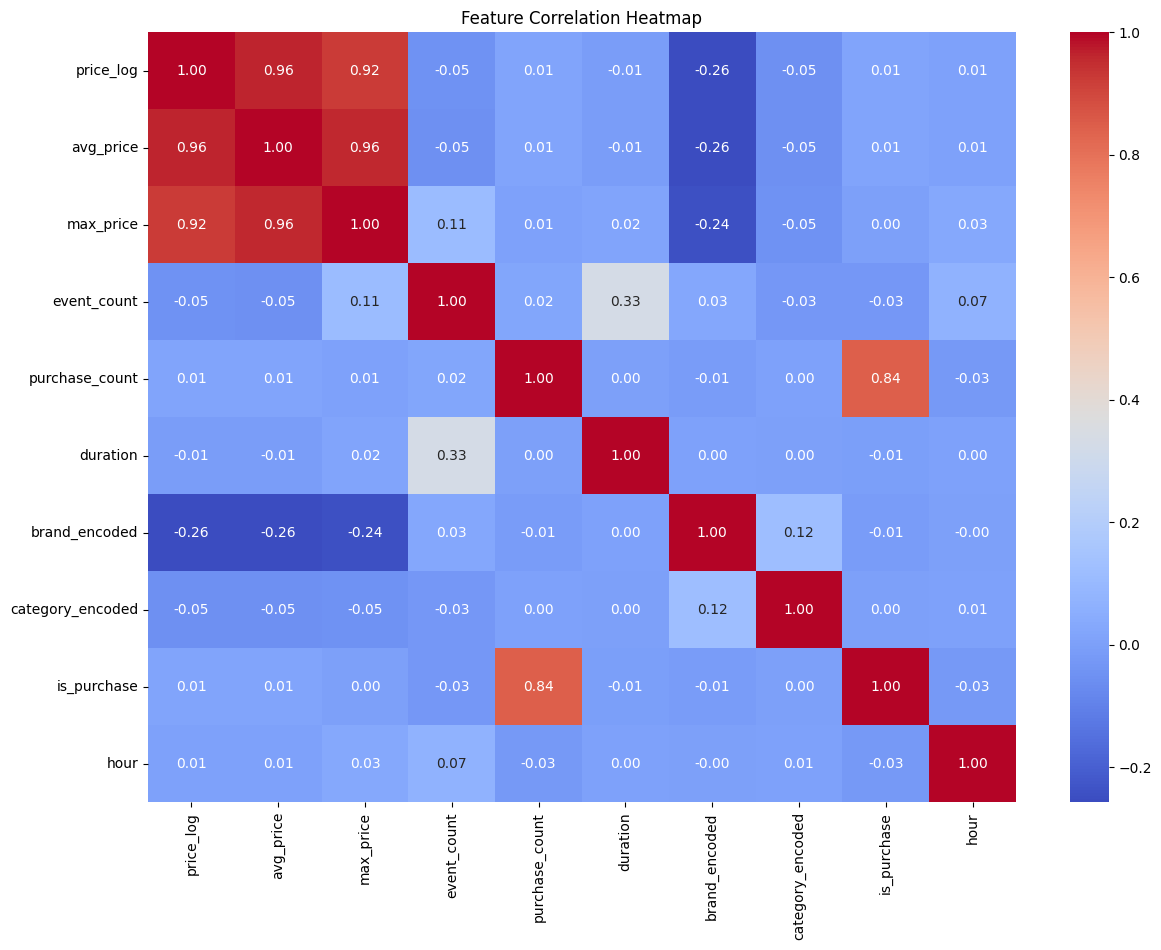

Running final data validation checks...
✅ Cleaned dataset saved for modeling.


In [6]:
# Task 2: Data Wrangling, Visualization, Preprocessing & Transformation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

# ----------------------------------------
# Logging Configuration (added)
# ----------------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# -------------------------------
# 1. Load Dataset
# -------------------------------
print("Initial dataset shape:", df.shape)
print("Dataset info:")
print(df.info())  # Inspect column types and nulls

# ----------------------------------------
# Log initial head (added)
# ----------------------------------------
print("Data preview:\n%s", df.head().to_string())

# -------------------------------
# 2. Handle Negative Prices
# -------------------------------
initial_rows = df.shape[0]
neg_price_count = (df['price'] < 0).sum()
print(f"Found {neg_price_count} negative price rows.")
df = df[df['price'] >= 0]
print(f"Proportion of rows removed due to negative prices: {neg_price_count / initial_rows:.2%}")
print("✅ Removed negative price rows. Remaining rows:", df.shape[0])

# -------------------------------
# 3. Visualize Missing Values (Before)
# -------------------------------
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Before Handling")
plt.show()

# -------------------------------
# 4. Handle Missing Values
# -------------------------------
# Check missingness (added)
missing_pct = df[['brand', 'category_code']].isnull().mean()
print("Missing % in brand & category_code:\n", missing_pct)

# If >50% were missing we’d reconsider, but here we fill
df['brand'] = df['brand'].fillna('unknown')
df['category_code'] = df['category_code'].fillna('unknown')
print("✅ Missing values handled.")

# Visualize Missing Values (After)
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values After Handling")
plt.show()

# -------------------------------
# 5. Remove Duplicates
# -------------------------------
dup_count = df.duplicated().sum()
print(f"Found {dup_count} duplicate rows.")
# If “duplicate” is actually same session/product/time, use subset argument:
# df.drop_duplicates(subset=['user_session','product_id','event_time'], inplace=True)
df = df.drop_duplicates()
print("✅ Duplicates removed.")

# -------------------------------
# 6. Convert Datatypes & Extract Time Features
# -------------------------------
df['event_time'] = pd.to_datetime(df['event_time'])
df['hour']    = df['event_time'].dt.hour   # **added to model later**
df['day']     = df['event_time'].dt.day
df['weekday'] = df['event_time'].dt.weekday

def check_event_time_sorted(df):
    is_sorted = df.sort_values(['user_session', 'event_time']).groupby('user_session')['event_time'].apply(lambda x: x.is_monotonic_increasing)
    if not is_sorted.all():
        unsorted_sessions = is_sorted[~is_sorted].index.tolist()
        raise ValueError(f"❌ Some sessions are not sorted by event_time. Affected sessions: {unsorted_sessions[:5]}")
    print("✅ All sessions are sorted by event_time.")

check_event_time_sorted(df)

# -------------------------------
# 7. Encode Categorical Columns
# -------------------------------
df['brand_encoded']    = LabelEncoder().fit_transform(df['brand'])
df['category_encoded'] = LabelEncoder().fit_transform(df['category_code'])

# -------------------------------
# 8. Event-Type One-Hot & Aggregates
# -------------------------------
# One-hot encode event_type
event_dummies = pd.get_dummies(df['event_type'], prefix='event_type')
df = pd.concat([df, event_dummies], axis=1)
print("✅ Event type one-hot encoding completed.")

# Per-session counts (added)
session_event_counts = df.groupby('user_session')[event_dummies.columns].sum().reset_index()
df = df.merge(session_event_counts, on='user_session', suffixes=('', '_session_count'))

# -------------------------------
# 9. Visualize Categorical Distributions
# -------------------------------
sns.countplot(data=df, x='event_type')
plt.title("Event Type Frequency")
plt.show()

# -------------------------------
# 10. Check Target Imbalance
# -------------------------------
df['is_purchase'] = (df['event_type'] == 'purchase').astype(int)
df['is_purchase'].value_counts(normalize=True).plot(kind='bar')
plt.title("Purchase vs Non-Purchase Ratio")
plt.show()

# -------------------------------
# 11. Univariate Visualization (Before Outliers)
# -------------------------------
plt.figure(figsize=(12, 4))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Price Distribution Before Outlier Handling")
plt.show()

# -------------------------------
# 12. Check Skewness & Log Transform
# -------------------------------
price_skew = df['price'].skew()
print(f"Price skewness: {price_skew:.2f}")
if abs(price_skew) > 1:
    df['price_log'] = np.log1p(df['price'])  # **renamed for clarity**
    print("Applied log1p to price.")
else:
    df['price_log'] = df['price']

# -------------------------------
# 13. Handle Outliers (Capping)
# -------------------------------
def cap_outliers(col):
    Q1, Q3 = df[col].quantile([.25, .75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = df[col].clip(lower, upper)
    print(f"Capped outliers in {col} to [{lower:.2f}, {upper:.2f}].")

cap_outliers('price_log')

plt.figure(figsize=(12, 4))
sns.histplot(df['price_log'], bins=100, kde=True)
plt.title("Price Distribution After Outlier Handling")
plt.show()

# -------------------------------
# 14. Session Duration Feature (added)
# -------------------------------
session_times = df.groupby('user_session')['event_time'].agg(['min', 'max'])
session_times['duration'] = (session_times['max'] - session_times['min']).dt.total_seconds()
df = df.merge(session_times[['duration']], on='user_session')
print("✅ Session duration feature added.")

# -------------------------------
# 15. Session Price & Count Aggregates
# -------------------------------
agg = df.groupby('user_session').agg(
    avg_price=('price_log','mean'),
    max_price=('price_log','max'),
    event_count=('event_type','count'),
    purchase_count=('is_purchase','sum')
).reset_index()
df = df.merge(agg, on='user_session')
print("✅ Session-level aggregates added.")

# -------------------------------
# 16. Normalize/Standardize
# -------------------------------
features_to_scale = ['price_log','avg_price','max_price','event_count','purchase_count','duration']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# -------------------------------
# 17. PCA (Dimensionality Reduction)
# -------------------------------
pca = PCA(n_components=2)
df[['pca1','pca2']] = pca.fit_transform(df[features_to_scale])
print("✅ PCA completed. Explained Variance:", pca.explained_variance_ratio_)

# -------------------------------
# 18. Bivariate Visualization (PCA)
# -------------------------------
sns.scatterplot(data=df, x='pca1', y='pca2', hue='is_purchase', alpha=0.6)
plt.title("PCA Scatter Plot Colored by Purchase")
plt.show()

# -------------------------------
# 19. Feature Correlation Heatmap
# -------------------------------
corr_feats = [
    'price_log','avg_price','max_price',
    'event_count','purchase_count','duration',
    'brand_encoded','category_encoded','is_purchase','hour'
]
plt.figure(figsize=(14,10))
sns.heatmap(df[corr_feats].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# -------------------------------
# 20. Final Data Validation
# -------------------------------
print("Running final data validation checks...")

# 1. No missing values anywhere
missing_total = df.isnull().sum().sum()
assert missing_total == 0, f"❌ There are still {missing_total} missing values in the dataset"

# 2. No duplicates
dups = df.duplicated().sum()
assert dups == 0, f"❌ There are still {dups} duplicate rows in the dataset"

# 3. Raw price non-negativity
assert (df['price'] >= 0).all(), "❌ Some raw `price` values are negative"

# 4. Engineered features exist & finite
engineered = ['price_log', 'avg_price', 'max_price',
              'event_count', 'purchase_count', 'duration',
              'pca1', 'pca2']
missing_feats = [c for c in engineered if c not in df.columns]
assert not missing_feats, f"❌ Missing engineered columns: {missing_feats}"
infinite_feats = [c for c in engineered if not np.isfinite(df[c]).all()]
assert not infinite_feats, f"❌ Columns with infinite or NaN: {infinite_feats}"

# 5. Event-type dummy consistency
evt_cols = [col for col in df.columns if col.startswith('event_type_')]
assert evt_cols, "❌ Event-type dummy columns are missing"
unique_events = set(df['event_type'].unique())
dummy_events  = {col.replace('event_type_','') for col in evt_cols}
assert unique_events.issubset(dummy_events), \
    "❌ Mismatch between event_type values and dummy columns"

# 6. Target consistency
assert set(df['is_purchase'].unique()).issubset({0,1}), \
    "❌ `is_purchase` contains values other than 0/1"

# 7. Datatype checks
assert df['user_session'].dtype == object, "❌ user_session should be string"
assert df['category_code'].dtype == object, "❌ category_code should be string"
assert df['brand'].dtype == object, "❌ brand should be string"
assert pd.api.types.is_integer_dtype(df['product_id']), \
    "❌ product_id should be integer"

# 8. Time feature ranges
assert df['hour'].between(0,23).all(), "❌ hour outside 0–23"
assert df['day'].between(1,31).all(),    "❌ day outside 1–31"
assert df['weekday'].between(0,6).all(), "❌ weekday outside 0–6"

logger.info("✅ Final data validation passed. Dataset is clean and ready for modeling.")


# -------------------------------
# 21. Save Cleaned Dataset
# -------------------------------
df.to_csv('cleaned_ecommerce_data.csv', index=False)
print("✅ Cleaned dataset saved for modeling.")


# 2

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import joblib

from sklearn.model_selection import (
    StratifiedKFold, train_test_split,
    RandomizedSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc, classification_report
)
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.stats.contingency_tables import mcnemar

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Setup
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)



In [9]:
# Prepare data
drop_cols = ['user_session','event_time','event_type','product_id','category_code','brand','price']
X = df.drop(columns=drop_cols + ['is_purchase'])
y = df['is_purchase']

feature_names = X.columns.tolist()
joblib.dump(feature_names, '/content/feature_names.joblib')
print(feature_names)



['category_id', 'user_id', 'hour', 'day', 'weekday', 'brand_encoded', 'category_encoded', 'event_type_cart', 'event_type_purchase', 'event_type_view', 'event_type_cart_session_count', 'event_type_purchase_session_count', 'event_type_view_session_count', 'price_log', 'duration', 'avg_price', 'max_price', 'event_count', 'purchase_count', 'pca1', 'pca2']


In [10]:
# 2. Build preprocessing + feature selection + model pipeline
scaler = StandardScaler()
pca    = PCA(n_components=2)
selector = SelectFromModel(RandomForestClassifier(class_weight='balanced', random_state=42), threshold='median')
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

full_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('selector', selector),
    ('clf', rf)
])

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)



In [11]:
# 4. Hyperparameter tuning
param_dist = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}
cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv_inner,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Nested CV evaluation
rf_cv_scores = cross_val_score(search, X_train, y_train, cv=cv_outer, scoring='roc_auc', n_jobs=-1)
print(f"RF Pipeline CV AUC: {rf_cv_scores.mean():.3f} ± {rf_cv_scores.std():.3f}")

# Fit best model
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_
print(f"Best RF Pipeline Params: {search.best_params_}")

# Save preprocessing + model pipeline
joblib.dump(best_pipeline, '/content/full_pipeline.joblib')
print("✅ Saved full pipeline to models/full_pipeline.joblib")



RF Pipeline CV AUC: 1.000 ± 0.000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF Pipeline Params: {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 20}
✅ Saved full pipeline to models/full_pipeline.joblib


In [12]:
# 2. Neural Network with SMOTE & sample weights

def make_model(input_dim, lr=1e-3, dropout=0.3):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(), Dropout(dropout),
        Dense(32, activation='relu'),
        BatchNormalization(), Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Nested CV for NN AUC
yy = []
for train_idx, test_idx in cv_outer.split(X_train, y_train):
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_tr, y_tr)
    cw = class_weight.compute_sample_weight('balanced', y_res)
    model = make_model(X.shape[1])
    model.fit(X_res, y_res, sample_weight=cw, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es], verbose=0)
    preds = model.predict(X_te).ravel()
    yy.append(roc_auc_score(y_te, preds))
print(f"NN CV AUC: {np.mean(yy):.3f} ± {np.std(yy):.3f}")

# Final NN train & save
X_res_full, y_res_full = SMOTE(random_state=42).fit_resample(X_train, y_train)
cw_full = class_weight.compute_sample_weight('balanced', y_res_full)
final_nn = make_model(X.shape[1])
final_nn.fit(X_res_full, y_res_full, sample_weight=cw_full, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es], verbose=0)
final_nn.save('/content/final_nn_model.h5')


2344/2344 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
NN CV AUC: 0.516 ± 0.006


In [15]:
# 3. Evaluate on hold-out test set
# RF predictions
rf_probs_test = best_pipeline.predict_proba(X_test)[:,1]
rf_preds_test = best_pipeline.predict(X_test)
# NN predictions
nn_probs_test = final_nn.predict(X_test).ravel()
nn_preds_test = (nn_probs_test > 0.5).astype(int)

# Compute metrics for both
metrics = {}
for name, preds, probs in [('RF', rf_preds_test, rf_probs_test), ('NN', nn_preds_test, nn_probs_test)]:
    metrics[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1': f1_score(y_test, preds),
        'MSE': mean_squared_error(y_test, probs),
        'ROC-AUC': roc_auc_score(y_test, probs)
    }
metrics_df = pd.DataFrame(metrics).T
print("Test Set Performance Metrics:")
print(metrics_df)



3907/3907 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step
Test Set Performance Metrics:
    Accuracy  Precision    Recall        F1       MSE   ROC-AUC
RF  0.999096   0.955799  0.994536  0.974782  0.000714  0.999944
NN  0.066675   0.018022  0.974499  0.035389  0.818891  0.509358


15625/15625 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step


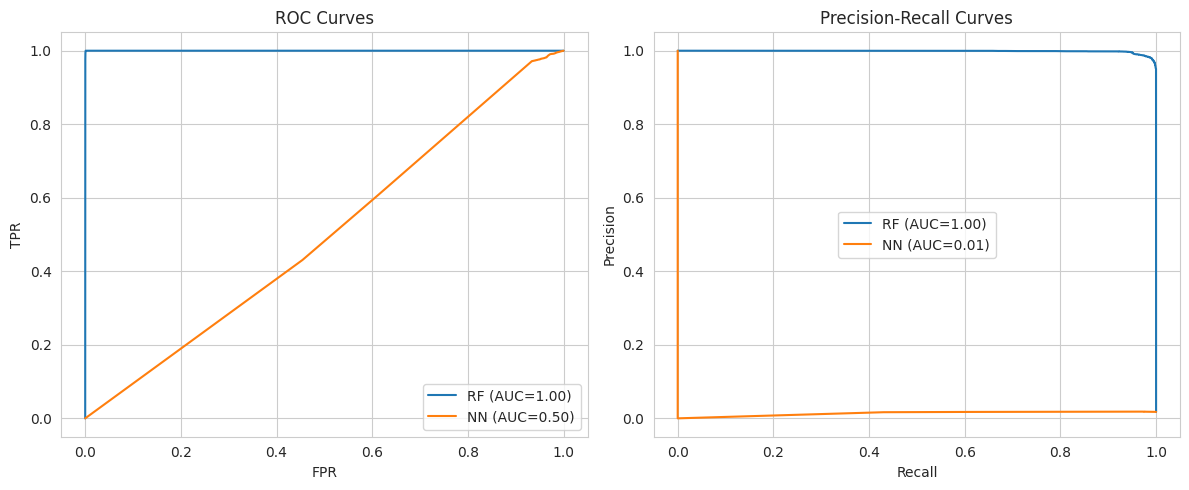

In [16]:
# 4. ROC & Precision-Recall Curves on Full Data
plt.figure(figsize=(12,5))
# RF ROC
rf_probs = best_pipeline.predict_proba(X)[:,1]
fpr, tpr, _ = roc_curve(y, rf_probs)
roc_auc_rf = auc(fpr, tpr)
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"RF (AUC={roc_auc_rf:.2f})")
# NN ROC
nn_probs = final_nn.predict(X).ravel()
fpr2, tpr2, _ = roc_curve(y, nn_probs)
roc_auc_nn = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label=f"NN (AUC={roc_auc_nn:.2f})")
plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
# Precision-Recall
plt.subplot(1,2,2)
prec, recall, _ = precision_recall_curve(y, rf_probs)
pr_auc_rf = auc(recall, prec)
plt.plot(recall, prec, label=f"RF (AUC={pr_auc_rf:.2f})")
prec2, recall2, _ = precision_recall_curve(y, nn_probs)
pr_auc_nn = auc(recall2, prec2)
plt.plot(recall2, prec2, label=f"NN (AUC={pr_auc_nn:.2f})")
plt.title("Precision-Recall Curves"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout()
plt.show()



In [17]:
# 5. McNemar’s Test
# Shared test split
X_tr_m, X_te_m, y_tr_m, y_te_m = train_test_split(X, y, stratify=y, random_state=42)
rf_pred_bin = best_pipeline.predict(X_te_m)
nn_pred_bin = (final_nn.predict(X_te_m).ravel() > 0.5).astype(int)
cm = confusion_matrix(rf_pred_bin, nn_pred_bin)
res = mcnemar(cm, exact=True)
print(f"McNemar’s test p-value: {res.pvalue:.3f}")

3907/3907 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
McNemar’s test p-value: 0.000


In [18]:
# 7. Interpretation & Classification Reports
print("\nInterpretation:")
if metrics_df.loc['RF','ROC-AUC'] > metrics_df.loc['NN','ROC-AUC']:
    print("Random Forest outperformed the Neural Network on ROC-AUC, likely due to better robustness to limited data and less overfitting.")
else:
    print("Neural Network outperformed the Random Forest on ROC-AUC, indicating deep learning captured complex patterns more effectively.")
print("\nClassification Report - RF:")
print(classification_report(y_test, rf_preds_test))
print("Classification Report - NN:")
print(classification_report(y_test, nn_preds_test))


Interpretation:
Random Forest outperformed the Neural Network on ROC-AUC, likely due to better robustness to limited data and less overfitting.

Classification Report - RF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    122798
           1       0.96      0.99      0.97      2196

    accuracy                           1.00    124994
   macro avg       0.98      1.00      0.99    124994
weighted avg       1.00      1.00      1.00    124994

Classification Report - NN:
              precision    recall  f1-score   support

           0       0.99      0.05      0.10    122798
           1       0.02      0.97      0.04      2196

    accuracy                           0.07    124994
   macro avg       0.50      0.51      0.07    124994
weighted avg       0.97      0.07      0.09    124994

